# Transfer Learning using TensorFlow Hub
- Our model worked great for Fashion-MNIST, but sucked for CIFAR10
- CIFAR10 is a lot more complex
    - 3 color channels results in triple the amount of inputs
    - Background imagery adds noise
    - Not always centered
- We need a model that can recognize spatial structures and patterns
    - This info is lost if we flatten the input from the beginning
- The [TensorFlow Hub](https://tfhub.dev) provides access to many pre-trained models
    - Easy-to-use libraries and web API calls
    - Saves time and resources
- Transfer learning is made of 2 components
    - Pretraining
        - Training model from scratch
        - Randomly initialized weights
        - Trained on lots of images across many domains
    - Fine-tuning
- Benefits
    - Faster development
    - Less data needed to fine-tune
    - Excellent results

## Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

## Load Dataset
- Here we fetch the flower dataset and save it.

In [2]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)
data_dir

'C:\\Users\\Me\\.keras\\datasets\\flower_photos'

- Next we convert the images into dataset objects

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 128 

train_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset='training',
    seed=1,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset='validation',
    seed=1,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

class_names = np.array(train_ds.class_names)
class_names

Found 3670 files belonging to 1 classes.
Using 2936 files for training.
Found 3670 files belonging to 1 classes.
Using 734 files for validation.


array(['flower_photos'], dtype='<U13')

- We also need to normalize the pixels to a range of 0-1

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) 
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) 

- Autotune lets us dynamically fetch data
- Model doesn't have to wait for all the data before starting
    - Can start with initial data and continues to receive new data as it finishes processing current

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 224, 224, 3)
(128,)


## Using TensorFlow Hub

### Load Pretrained Model

In [6]:
inception_v3 = 'https://tfhub.dev/google/imagenet/inception_v3/classification/5'
IMAGE_SHAPE = (224, 224)

hub_layer = hub.KerasLayer(inception_v3, input_shape=IMAGE_SHAPE + (3,))
classifier = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: hub_layer(x))
])


labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

### Run Without Fine-Tuning

23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step


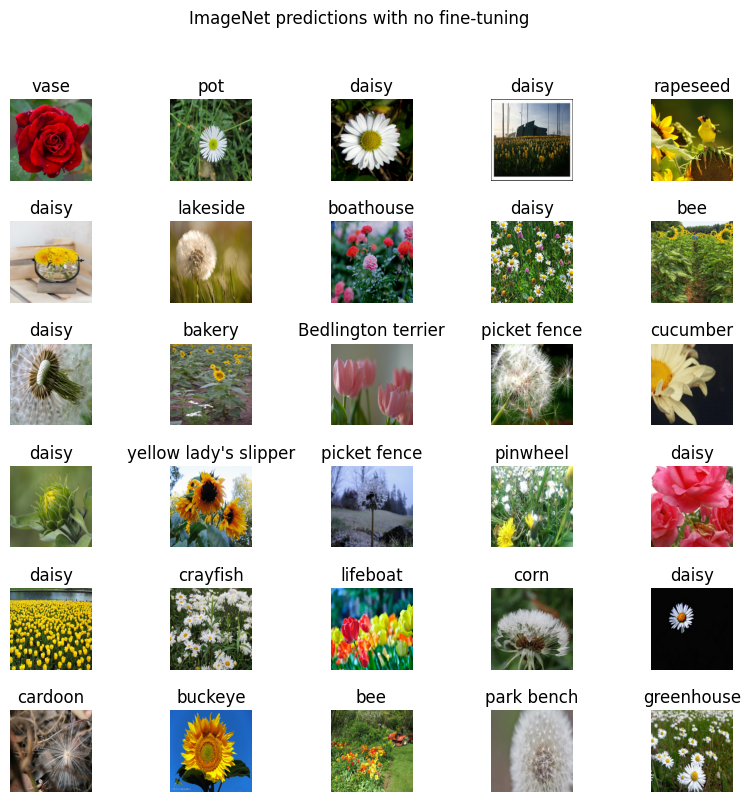

In [7]:
result_batch = classifier.predict(train_ds)
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('ImageNet predictions with no fine-tuning')
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')

### Transfer Learning
- We add a layer to the model with 5 classes
- Corresponds to our flower dataset's classes
    - Fully-connected layer

In [8]:
NUM_CLASSES = len(class_names)
feature_extractor_model = inception_v3
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False
)

model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: feature_extractor_layer(x)),
    tf.keras.layers.Dense(NUM_CLASSES)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training

### Train Model

In [11]:
NUM_EPOCHS = 10

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS
).history

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - acc: 0.8479 - loss: 0.0000e+00 - val_acc: 0.8733 - val_loss: 0.0000e+00
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - acc: 0.8479 - loss: 0.0000e+00 - val_acc: 0.8733 - val_loss: 0.0000e+00
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - acc: 0.8479 - loss: 0.0000e+00 - val_acc: 0.8733 - val_loss: 0.0000e+00
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - acc: 0.8479 - loss: 0.0000e+00 - val_acc: 0.8733 - val_loss: 0.0000e+00
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - acc: 0.8479 - loss: 0.0000e+00 - val_acc: 0.8733 - val_loss: 0.0000e+00
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - acc: 0.8479 - loss: 0.0000e+00 - val_acc: 0.8733 - val_loss: 0.0000e+00
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - acc: 0.8479 - loss: 0.0000e+00 - val_acc: 0.8733 - val_loss: 0.0000e+00
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - acc: 0.8479 - loss: 0.0000e+00 - val_acc: 0.8733 - val_loss: 0.0000e+00
Epoc

### View Loss/Accuracy
- Loss decreases as we train
- Accuracy increases

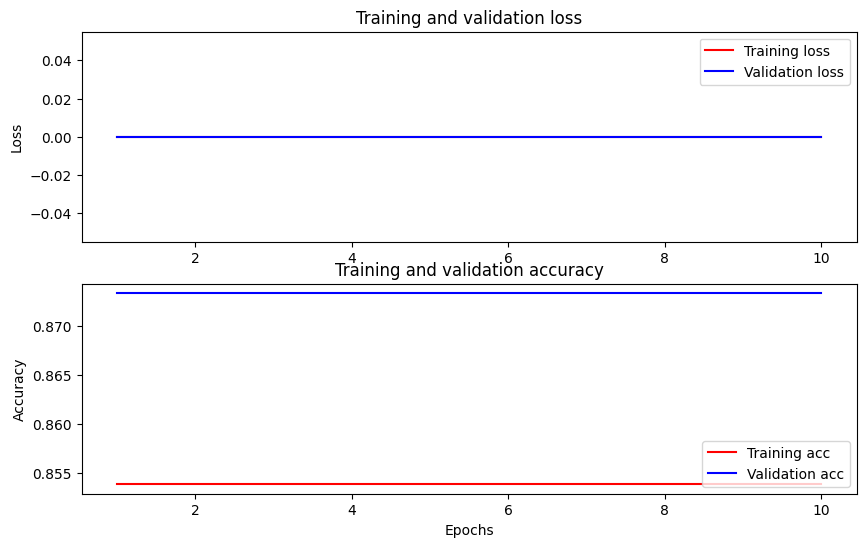

In [12]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

## Predict

### Create Batch
- We can see that this batch has 128 images
- 5 columns corresponding to each of the classes

In [13]:
image_batch, labels = next(iter(val_ds))

predicted_batch = model.predict(image_batch)
print('Batch shape:', predicted_batch.shape)
print('Classes:', class_names)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 919ms/step
Batch shape: (128, 1)
Classes: ['flower_photos']


### Make Predictions
- We use `argmax` to get the column with the highest score

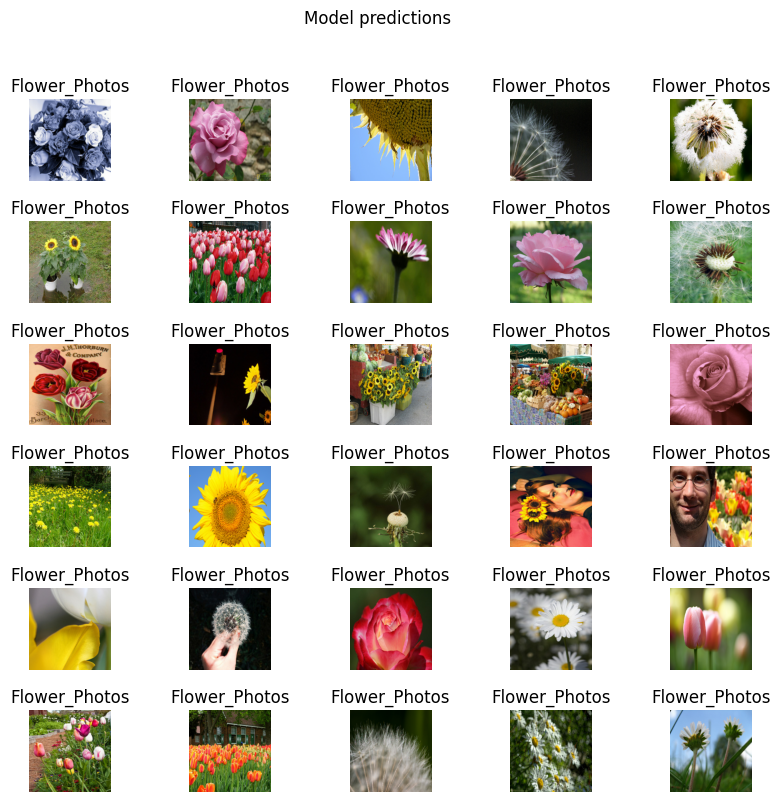

In [14]:
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Model predictions')
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')